# Análise das licitações no Rio Grande do Sul
Por Patrick Luiz de Araújo.

Desafio: propõe-se a análise de uma base com as licitações dos órgãos públicos do Rio Grande do Sul. A base contém informações de 2016 a 2019.


## Processo
A análise feita possui os seguintes passos:
- Tratamento dos dados: tratamento dos dados, tais como exclusão de "stop words", exclusão de pontuação, tokenização, etc;
- Codificação: uso de técnicas para codificar o texto tokenizado;
- Modelagem: uso de modelos para agrupar os objetos das licitações em conjuntos comuns;
- Análise exploratória dos dados: busca de insights.

# Importação de bibliotecas e da base

In [1]:
# Importação de bibliotecas
import pandas as pd 
import numpy as np
import sys
import os
#
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
#
from tqdm import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Libs adicionais de NLP
import spacy 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
#
from sklearn.cluster import KMeans

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#
from matplotlib.ticker import FuncFormatter

import pprint

In [25]:
nlp=spacy.load('pt_core_news_lg') # Uso do core 'pt_core_news_lg' do Spacy

nltk.download('stopwords') # Download das stopworks do NLTK

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
filenames = os.listdir('base') # Arquivos da base de dados

In [119]:
licita = [] # Receberá os dataframes das licitações separados por ano
licita_all = np.NaN # Receberá o dataframe resultante da soma de todas as bases de licitação

# Colunas usadas na análise da base de licitações
cols = ['CD_ORGAO', 'NM_ORGAO', 'NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE', 'NR_COMISSAO', 'ANO_COMISSAO', 'TP_COMISSAO', 'NR_PROCESSO', 'ANO_PROCESSO', 'TP_OBJETO', 'CD_TIPO_FASE_ATUAL', 'TP_LICITACAO', 'DS_OBJETO', 'VL_LICITACAO', 'VL_HOMOLOGADO']

for path in filenames:
    aux = pd.read_csv(os.path.join('base', path, 'licitacao.csv'), usecols=cols)

    licita.append(aux)

    if type(licita_all)==type(np.NaN):
        licita_all = aux

    else:
        licita_all = licita_all.append(aux)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
item = [] # Receberá os dataframes dos itens licitados separados por ano
item_all = np.NaN # Receberá o dataframe resultante da soma de todas as bases de itens licitados

for path in filenames:
    aux = pd.read_csv(os.path.join('base', path, 'item.csv'), usecols=[n for n in range (0,13)])

    item.append(aux)

    if type(item_all)==type(np.NaN):
        item_all = aux

    else:
        item_all = item_all.append(aux)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
# Drop de nulls
item_all = item_all.dropna()
licita_all = licita_all.dropna()

# Tratamento dos dados
Os dados da base possuem uma série de erros, necessitando de um tratamento preliminar. Os passos adotaddos foram:
- Transformação dos caracteres para usarem somente caixa baixa;
- Exclusão de caracteres especiais
- Exclusão de dígitos;
- Exclusão de barras;
- Exclusão de espaçamentos repetitivos;
- Tokenização;
- Exclusão de stopwords e elementos especiais (fruto de análise manual dos registros).

In [106]:
stopwords = nltk.corpus.stopwords.words('portuguese') # Carregamento das stopwords em português

# Caracteres especiais a serem deletados. Sendo unidades de medida e símbolos especiais que não agregam valor a análise
filter_out = stopwords + ['kg', 'm', 'cm', 'mm', 'mg', 'ml', 'm²', '-', '+', '=', 'mcg', 'nº', 'g', 'ª', 'º']

# Função de tratamento
def processing_tokenization(sentence):
    sentence = sentence.lower() # Caixa baixa
    sentence = re.sub(r"[^\w\s]", "",sentence) # Exclusão de caracteres especiais
    sentence = re.sub("[0-9]+","", sentence) # Exclusão de dígitos
    sentence = re.sub("/+","", sentence) # Exclusão de "/"
    sentence = re.sub(' +', ' ', sentence) # Exclusão de espaçamentos repetitivos entre as frases

    doc=nlp(sentence) # Tokenização

    tokens=[token.text for token in doc]
    tokens=[token for token in tokens if token not in filter_out] # Filtragem adicional com os caracteres em filter_out

    return tokens

In [107]:
# Aplicação do tratamento na lista de itens licitados e salvando os dados
item_all['DS_ITEM_TRATADO'] = item_all['DS_ITEM'].apply(lambda x: processing_tokenization(x))
item_all.to_csv('base/item_tratado.csv')

In [120]:
# Aplicação do tratamento na lista de licitações e salvando os dados
licita_all['DS_OBJETO_TRATADO'] = licita_all['DS_OBJETO'].apply(lambda x: processing_tokenization(x))
licita_all.to_csv('base/licita_tratado.csv')

# Construção do modelo de clusterização
Após o tratamento das bases, busca-se construir um modelo que consiga segmentar os itens licitados e as licitações. Esta fase é importante por permitir uma análise completa dos dados. As seguintes hipóteses foram testadas:

**Bag of Words + LDA:** os campos de descrição da base foram tratados por meio do Bag of Words (BoW) e clusterizados por meio do Lathend Dirichlet Allocation, um algoritmo de clusterização não supervisionado.

**Doc2Vec + KMeans:** os textos foram codificados por meio do Doc2Vec, um algoritmo de vetorização similar ao Word2Vec, mas que vetoriza todo um texto ao invés de uma única palavra. Com as descrições vetorizadas, o algoritmo de clusterização não supervisionado KMeans foi testado para tentar construir um cluster dos dados.

**Tfidf + KMeans:** os textos foram codificados por meio do Tfidf, um algoritmo que codifica os textos por meio de uma função de frequência inversa nas palavras. Com as descrições vetorizadas, o KMeans também foi testado para tentar clusterizar a informação resultante.

Após o teste das abordagens, aquela que promoveu a melhor separabilidade dos dados foi escolhida analisando os clusters construídos.

## Abordagem 1 - Bag of Words + LDA

In [123]:
# Dicionário
id2word = corpora.Dictionary(item_all['DS_ITEM_TRATADO'])

# Corpus
texts = item_all['DS_ITEM_TRATADO']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Visualização
print(corpus[:1])

###
# Equivalente Spacy
#vectorizer = CountVectorizer()
#vector = vectorizer.fit_transform(item_all['DS_ITEM_TRATADO'])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [124]:
# Corpus num formado simplificado (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('doses', 1),
  ('fluticasona', 1),
  ('frasco', 1),
  ('propionato', 1),
  ('salmeterol', 1),
  ('xinafoato', 1)]]

Primeiramente é necessário testar qual o valor ideal de clusters para esta abordagem. Para isso, uma função que mede a coerência do LDA será usada iterativamente para avaliar a quantidade ideal de clusters. 

In [142]:
# Função para computar a coerência dos tópicos
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [184]:
start=5
limit=36
step=5

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=item_all['DS_ITEM_TRATADO'], start=start, limit=limit, step=step)

100%|██████████| 7/7 [21:12<00:00, 181.72s/it]


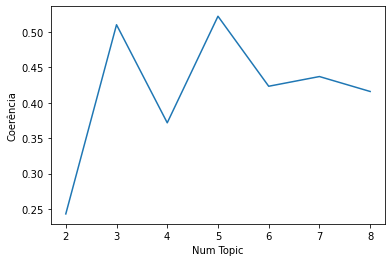

[0.24294453966412233,
 0.5103797146695515,
 0.37175651549686145,
 0.5223851992340858,
 0.42341528316379023,
 0.4371406888989532,
 0.4160209107276964]

In [185]:
# Show graph
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topic")
plt.ylabel("Coerência")
plt.show()

coherence_values

Conforme visto, há um pico de coerência para 3 e 5 clusters. Já que 3 clusters é um número muito pequeno para separar os dados, Um LDA com 5 tópicos foi usado.

In [186]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           per_word_topics=True)

###
# Equivalente Spacy
#from sklearn.decomposition import LatentDirichletAllocation
#LDA = LatentDirichletAllocation(random_state=42, n_components=7)
#LDA.fit(vector)

As palavras mais significantes para cada tópico podem ser consultadas por meio do modelo. Aqui estão os resultados:

In [187]:
pp = pprint.PrettyPrinter()

# Print the Keyword in the 10 topics
pp.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

###
# Equivalente Spacy
#for i, topic in enumerate(LDA.components_):
#    print(f"THE TOP 15 WORDS FOR TOPIC #{i}")
#    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-15:]])
#    print('\n\n')

[(0,
  '0.045*"x" + 0.030*"_" + 0.014*"transporte" + 0.013*"placa" + 0.012*"af" + '
  '0.012*"aço" + 0.012*"madeira" + 0.011*"pneu" + 0.011*"r" + 0.010*" "'),
 (1,
  '0.026*"x" + 0.024*"cor" + 0.017*"c" + 0.016*"caixa" + 0.012*"tamanho" + '
  '0.011*"papel" + 0.011*"branca" + 0.008*"branco" + 0.008*"largura" + '
  '0.008*"unidades"'),
 (2,
  '0.018*"concreto" + 0.018*"fornecimento" + 0.017*"termo" + 0.017*"conforme" '
  '+ 0.017*"pvc" + 0.016*"instalação" + 0.012*"referência" + 0.011*"af" + '
  '0.010*"tubo" + 0.009*"construção"'),
 (3,
  '0.014*"base" + 0.012*"pintura" + 0.012*"tinta" + 0.011*"\t" + 0.010*"w" + '
  '0.009*"cabo" + 0.008*"sistema" + 0.008*"mínimo" + 0.007*"v" + 0.007*"luva"'),
 (4,
  '0.030*"embalagem" + 0.014*"validade" + 0.014*"produto" + 0.011*"tipo" + '
  '0.010*"data" + 0.009*"qualidade" + 0.008*"mínimo" + 0.008*"ser" + '
  '0.008*"meses" + 0.008*"peso"')]


In [188]:
# Perplexidade: menor é melhor
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Coerência: maior é melhor
coherence_model_lda = CoherenceModel(model=lda_model, texts=item_all['DS_ITEM_TRATADO'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.494030079770942

Coherence Score:  0.5223851992340858


É possível também exibir graficamente os clusters construídos. Conforme visto abaixo, com 5 clusters há uma boa separabilidade dos mesmos, visto que os clusters não se tocam e estão a uma distância confortável entre si.

In [189]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.312510  0.008876       1        1  26.059590
1     -0.154851 -0.181396       2        1  20.005970
4     -0.293186  0.034577       3        1  19.793902
0      0.121388 -0.211429       4        1  18.186910
3      0.014138  0.349372       5        1  15.953628, topic_info=          Term           Freq          Total Category  logprob  loglift
108          x  100679.000000  100679.000000  Default  30.0000  30.0000
435  embalagem   43919.000000   43919.000000  Default  29.0000  29.0000
708          _   40985.000000   40985.000000  Default  28.0000  28.0000
274        cor   39239.000000   39239.000000  Default  27.0000  27.0000
93    concreto   35416.000000   35416.000000  Default  26.0000  26.0000
..         ...            ...            ...      ...      ...      ...
503  aplicação    5258.336511    7376.087900   Topic5  -5.4237   1.4971
141     manual    6088.562422   12912.307957   Topic5  -5.2771   1.0837
262          p    5330.614713   18968.107765   Topic5  -5.4100   0.5662
148        uso    5020.228849   14144.224877   Topic5  -5.4700   0.7997
301     mínima    5022.552614   16426.117223   Topic5  -5.4696   0.6505

[265 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3545      5  0.999935      \t
1392      5  0.999728     \t 
681       1  0.392928        
681       4  0.607060        
708       4  0.999985       _
...     ...       ...     ...
2512      5  0.999950       w
108       2  0.386733       x
108       4  0.603023       x
108       5  0.010230       x
2949      5  0.999712  ônibus

[337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

Por fim, os clusters serão passados ao dataframe e salvos

In [190]:
def topic_prediction(corpus, lda_model):
    string_input = [corpus]
    X = string_input

    # Convert sparse matrix to gensim corpus.
    output = list(lda_model[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]

In [191]:
topics = []
for corp in tqdm(corpus):
    topics.append(topic_prediction(corp, lda_model))

item_all['topic'] = topics
item_all.to_csv('item_modeled_5_topics.csv')

100%|██████████| 966525/966525 [32:29<00:00, 495.87it/s]


In [209]:
pd.options.display.width = 1200
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [197]:
# Análise dos clusters
item_all[['DS_ITEM', 'topic']].tail(100)

,DS_ITEM,topic
884007,"1.3 RETIRADA DE POSTES DE CONCRETO DE 9, 11 E 12 METROS",0
884008,1.4 RETIRADA DE ESTRUTURAS DE MÉDIA E BAIXA TENSÃO EM VIA PÚBLICA,0
884009,"1.5 FORNECIMENTO E INSTALAÇÃO DE POSTE DE CONCRETO CÔNICO AUTO ATERRADO DE 9, 12 E 13 METROS",2
884010,1.6 FORNECIMENTO E INSTALAÇÃO DE ESTRUTURAS DE MÉDIA E BAIXA TENSÃO EM VIA PÚBLICA,2
884011,1.7 DESLOCAMENTO DE REDE DE MÉDIA E BAIXA TENSÃO PARA OS POSTES PROJETADOS,2
884012,2.1 FORNECIMENTO DE ART,2
884013,2.2 RETIRADA DE POSTE DE MADEIRA DE 11 METROS,0
884014,1.1 FORNECIMENTO DE ART,2
884015,2.3 RETIRADA DE ESTRUTURAS DE MÉDIA E BAIXA TENSÃO EM VIA PÚBLICA,0
884016,2.4 FORNECIMENTO E INSTALAÇÃO DE POSTE DE CONCRETO TRONCO CÔNICO AUTO ATERRADO DE 12M/4KN,2


Após uma análise dos clusters, é possível ver que o modelo construído não apresentou uma boa separabilidade dos dados para a base de objetos licitados. A seguir, a mesma análise será feita para a base de licitações para avaliar se há uma melhoria da abordagem.

In [198]:
# Dicionário
id2word = corpora.Dictionary(licita_all['DS_OBJETO_TRATADO'])

# Corpus
texts = licita_all['DS_OBJETO_TRATADO']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Visualizar
print(corpus[:1])

###
# Equivalente Spacy
#vectorizer = CountVectorizer()
#vector = vectorizer.fit_transform(item_all['DS_ITEM_TRATADO'])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [219]:
# Teste para buscar a quantidade ideal de clusters
start=10
limit=21
step=2

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=licita_all['DS_OBJETO_TRATADO'], start=start, limit=limit, step=step)

100%|██████████| 6/6 [09:07<00:00, 91.29s/it]


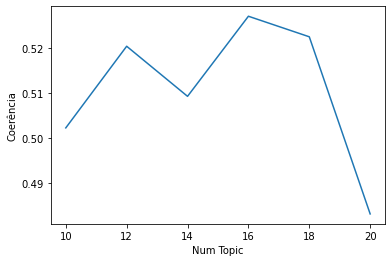

[0.5022256257270546,
 0.5204337584314972,
 0.5092634883687542,
 0.5271264543110462,
 0.5225432680275898,
 0.4830344244860081]

In [220]:
# Show graph
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topic")
plt.ylabel("Coerência")
plt.show()

coherence_values

Conforme visto, aqui há uma coerência maior para 16 tópicos. Este comportamento pode ser fruto de uma maior variedade de objetos licitados em relação a variedade de licitações. Exemplo: uma licitação para a área de transporte pode incluir os itens "mão-de-obra", pneu, óleo, etc.

In [221]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, 
                                           random_state=100,
                                           per_word_topics=True)

###
# Equivalente Spacy
#from sklearn.decomposition import LatentDirichletAllocation
#LDA = LatentDirichletAllocation(random_state=42, n_components=7)
#LDA.fit(vector)

In [222]:
import pprint
pp = pprint.PrettyPrinter()

# Print the Keyword in the 10 topics
pp.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

###
# Equivalente Spacy
#for i, topic in enumerate(LDA.components_):
#    print(f"THE TOP 15 WORDS FOR TOPIC #{i}")
#    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-15:]])
#    print('\n\n')

[(0,
  '0.063*"social" + 0.041*"assistência" + 0.030*"atividades" + '
  '0.023*"referente" + 0.020*"centro" + 0.017*"desenvolvimento" + '
  '0.016*"municipal" + 0.016*"oficinas" + 0.014*"exercício" + '
  '0.014*"município"'),
 (1,
  '0.080*"contratação" + 0.062*"empresa" + 0.053*"serviço" + 0.031*"serviços" '
  '+ 0.030*"municipal" + 0.028*"prestação" + 0.020*"transporte" + 0.017*"dias" '
  '+ 0.016*"câmara" + 0.016*"r"'),
 (2,
  '0.044*"contratação" + 0.044*"empresa" + 0.035*"execução" + 0.028*"obra" + '
  '0.022*"fornecimento" + 0.020*"projeto" + 0.018*"construção" + 0.017*"mão" + '
  '0.016*"rua" + 0.015*"global"'),
 (3,
  '0.067*"aquisição" + 0.059*"peças" + 0.054*"veículo" + 0.043*"conserto" + '
  '0.038*"ano" + 0.030*"placa" + 0.024*"manutenção" + 0.023*"km" + '
  '0.021*"obra" + 0.021*"caminhão"'),
 (4,
  '0.060*"processo" + 0.052*"lei" + 0.041*"n" + 0.031*"conforme" + '
  '0.021*"credenciamento" + 0.020*"federal" + 0.018*"art" + 0.018*"judicial" + '
  '0.017*"pagamento" + 0.016

In [223]:
# Perplexidade
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Coerência
coherence_model_lda = CoherenceModel(model=lda_model, texts=licita_all['DS_OBJETO_TRATADO'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.154804103177982

Coherence Score:  0.5271264543110462


In [224]:
# Visualize the topics
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.272124 -0.102289       1        1  10.898608
2     -0.189390 -0.044801       2        1   9.363925
1     -0.223617 -0.150060       3        1   8.520279
8      0.079559  0.234967       4        1   8.221839
11     0.165335 -0.046600       5        1   7.078857
13     0.226901 -0.167122       6        1   6.658705
14     0.197748 -0.104983       7        1   6.460104
7     -0.100640  0.086660       8        1   5.720190
3      0.094358 -0.118039       9        1   5.662190
6     -0.183898  0.020768      10        1   5.394213
4      0.021894  0.326456      11        1   4.834873
0     -0.026513  0.063080      12        1   4.806682
10     0.056660 -0.047375      13        1   4.709183
12     0.200074  0.007022      14        1   4.601833
15    -0.015468 -0.090543      15        1   3.742732
5     -0.030878  0.132856      16        1   3.325788, topic_info=              Term          Freq         Total Category  logprob  loglift
7        aquisição  94066.000000  94066.000000  Default  30.0000  30.0000
3      contratação  86262.000000  86262.000000  Default  29.0000  29.0000
141       serviços  56728.000000  56728.000000  Default  28.0000  28.0000
145       registro  25872.000000  25872.000000  Default  27.0000  27.0000
19         empresa  61903.000000  61903.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
443     realização   1365.484513  11485.671235  Topic16  -4.3729   1.2739
1607         poder    914.319071   1935.248610  Topic16  -4.7740   2.6537
1575         vinte    887.771572   1384.920389  Topic16  -4.8035   2.9588
524         litros    877.219312   1301.334712  Topic16  -4.8154   3.0091
21    fornecimento    892.295207  21523.332426  Topic16  -4.7984   0.2204

[841 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2545     10  0.725293   abril
2545     14  0.274594   abril
1637      2  0.252764  acesso
1637      3  0.685393  acesso
1637     10  0.061658  acesso
...     ...       ...     ...
1190     12  0.000974   óleos
3399     12  0.999168  órgãos
2586      9  0.999556  ônibus
2586     13  0.000348  ônibus
2721      5  0.999123   único

[1475 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 2, 9, 12, 14, 15, 8, 4, 7, 5, 1, 11, 13, 16, 6])

Conforme visto, apesar da quantidade significativamente maior de clusters, há pouca intersecção entre os conjuntos. A seguir, os documentos serão classificados.

In [205]:
topics = []
for corp in tqdm(corpus):
    topics.append(topic_prediction(corp, lda_model))

licita_all['topic'] = topics
licita_all.to_csv('item_modeled_16_topics.csv')

100%|██████████| 237011/237011 [11:11<00:00, 352.70it/s]


In [230]:
licita_all[licita_all['topic']==1][['DS_OBJETO','topic']].tail(100)

,DS_OBJETO,topic
61321,Fornecimento de Kit FUJIFILM ASK300 contendo 02 (dois) Rolos de Papel para impressora fotográfica térmica e 02 (dois) Ribbon.,5
61370,GASOLINA COMUM,5
61444,Aquisição de Gasolina Comum,5
61480,"Serviço de FISIOTERAPIA, totalizando 12 atendimentos mensais",5
61493,"Serviços de mão-de-obra de 20 (vinte) postos de trabalho para manutenção na rede de energia elétrica – rede debaixa, média e alta tensão- EXPOINTER/2019.",5
61514,"Serviços de locação, de 27(vinte sete) Carros elétricosmovidos a bateria para seremutilizados, em Esteio/RS, semmotoristas, de 22/08/2019 a02/09/2019.",5
61578,AQUISIÇÃO DE MATERIAL PARA COMANDO DA BOMBA SUBMERSA DO POÇO ARTESANAL LOCALIZADA NA COMUNIDADE DE MORRINHOS.,5
61585,44.000 (quarenta e quatro mil) unidades de munições 12/70 CH-3T TREINA HI-IMPACT,5
61706,"Jaqueta reversível. Nylon paraquedas impermeável, fabricada com nylon resinado: duas camadas de resina e uma de repelente a água. Dupla face reversível: um lado com bordado e outro lado sem bordado. Fibra interna de poliéster ou manta acrílica. Dois bolsos na linha da cintura, elastico nos dois punhos e cintura com barra, costura reforçada, ziper dentado frontal. Material poliamida resinado. Composição 100% poliamida resinado: duas camadas de resina e uma de repelente a água.",5
61818,Aquisição de 10 Termômetro Digital de máxima e mínima (-50° A +70°).,5


Conforme visto, houve uma melhoria na separabilidade dos tópicos, porém podem haver melhorias.

## Abordagem 2 - Doc2Vec + KMeans

In [334]:
# Conversão de documento tokenizado para o formato de dado taggeado do gensim
def tag_data(tokenized_doc):
    return [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]

In [335]:
# Treinamento do modelo de Doc2Vec
tagged_data = tag_data(licita_all['DS_OBJETO_TRATADO'])

model = Doc2Vec(tagged_data, min_count=30, workers=4, epochs = 100, ns_exponent=0.75)

100%|██████████| 14/14 [12:38<00:00, 54.21s/it]


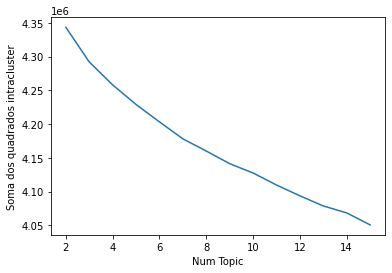

In [337]:
wcss = []
minimo=2
maximo=16
step=1

for n in tqdm(range(minimo, maximo, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=100)
    kmeans_model.fit(X=model.docvecs.doctag_syn0)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimo, maximo, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

Conforme visto acima, há uma boa convergência para 7 clusters.

In [338]:
kmeans_model = KMeans(n_clusters=7, init='k-means++', max_iter=100)

X = kmeans_model.fit(model.docvecs.doctag_syn0)

labels=kmeans_model.labels_.tolist()

licita_all['topic'] = labels 
licita_all.to_csv('licita_modeled_15_doc2vec.csv')

In [340]:
licita_all[licita_all['topic']==2][['DS_OBJETO','topic']].tail(100)

,DS_OBJETO,topic
70179,"Aquisição de equipamentos odontológicos conforme Termo de Compromisso Repasse nº4305831712181652247, do Fundo Nacional da Saúde, Ministério da Saúde",2
70182,"A presente licitação tem por objeto a locação de máquinas copiadoras e impressoras de documentos a serem utilizadas por diversas secretarias do Município de São Luiz Gonzaga, cujos dados quantitativos, qualitativos e custo estimado constam no Anexo II do presente Edital.",2
70185,AQUISIÇÃO DE EMULSÃO ASFÁLTICA RM-1C PARA USINA DE ASFALTO A FRIO.,2
70189,AQUISIÇÃO DE PEÇAS PARA RETROESCAVADEIRA JCB E CAMINHÃO FORD CARGO DA SECRETARIA DE OBRAS.,2
70195,"REGISTRO DE PREÇOS, resultantes das propostas de empresa(s) que ofereçam o menor custo para AQUISIÇÃO DE MEDICAMENTOS, SUPLEMENTOS ALIMENTARES E ALIMENTOS FUNCIONAIS PARA USO HUMANO, AOS MUNICÍPIOS CONSORCIADOS AO CONSISA VRT E AO SAMU VT, conforme Termo de Referência (ANEXO I).",2
70197,CONTRATAÇÃO DE CAMINHÕES PARA TRANSPORTE DE CASCALHO VISANDOI MELHORIAS NAS ESTRADAS DO INTERIOR.,2
70198,AQUISIÇÃO DE 112 M² DE LAJOTA PARA CALÇADA (PASSEIO) DA INCUBADORA DE EMPRESAS.,2
70218,"Rolo Compactador, ano 2014, Marca Maxloard, modelo MAX 212, potencia 150HP, peso operacional 12.000 Kg",2
70219,"Constitui objeto da presente licitação a contratação de empresa ou empresas para aquisição de materiais de artesanato e escolar para utilização nas diferentes oficinas de atividades artesanais, pelos usuários do CRAS, da Secretaria Municipal de Assistência Social e Habitação de Alegria-RS",2
70220,"Constitui objeto da presente licitação a contratação de empresa e ou empresas para aquisição de materiais para a construção das cortinas de contenção (cabeceiras), da Ponte na localidade de Barra Seca, divisa do Município de Alegria com São José do Inhacorá",2


Conforme visto, houve uma grande melhoria na performace por meio desta abordagem. No entanto, ainda não está ideal.

## Abordagem 3 - Tfidf Vectorizer + KMeans

In [300]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(min_df = 30, lowercase=False, tokenizer=identity_tokenizer)
tfidf = vectorizer.fit_transform(licita_all['DS_OBJETO_TRATADO'])

100%|██████████| 15/15 [13:16<00:00, 53.07s/it]


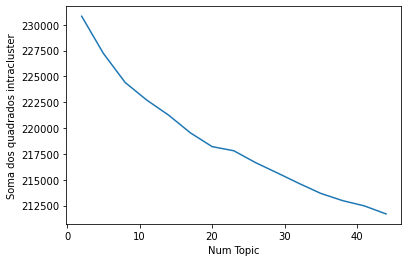

In [385]:
import warnings
warnings.filterwarnings('ignore')

wcss = []
minimo=2
maximo=45
step=3

for n in tqdm(range(minimo, maximo, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(tfidf)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimo, maximo, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

Conforme visto, 20 clusters pode apresentar um bom desempenho.

In [386]:
kmeans_model = KMeans(n_clusters=20, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)

X = kmeans_model.fit(tfidf)

labels=kmeans_model.labels_.tolist()

In [400]:
licita_all['topic'] = labels 
licita_all.to_csv('licita_modeled_20_tfidf.csv')

In [422]:
licita_all[licita_all['topic']==19][['DS_OBJETO','topic']].head(100)

,DS_OBJETO,topic
12,"Aquisição de cargas de gás liquefeito de petróleo P13 e P45, solicitados pela Secretaria Mun. de Educação, Cultura, Desporto e Lazer; Secretaria Mun. De Saúde, Secretaria Municipal de Assistência Social; Secretaria Municipal de Agricultura e Meio Ambiente; Secretaria Mun. De Obras, Viação, Habitação e Serviços Públicos e Secretaria Municipal de Administração",19
58,Aquisição de marmitex para a Secretaria Municipal de Obras e Trânsito,19
116,"Aquisição de cargas de gás liquefeito de petróleo P13 e P45, solicitados pela Secretaria Mun. de Educação, Cultura, Desporto e Lazer; Secretaria Mun. De Saúde, Secretaria Municipal de Assistência Social; Secretaria Municipal de Agricultura e Meio Ambiente; Secretaria Mun. De Obras, Viação, Habitação e Serviços Públicos e Secretaria Municipal de Administração em quantidades, unidades e especificações descritos no Anexo II do presente Edital.",19
193,"CONTRATAÇÃO DE EMPRESA PARA CONSERTO DO MICRO ONIBUS VOLARE PLACAS IOQ 7096, PERTENCENTE A SECRETARIA MUNICIPAL DE EDUCAÇÃO E DESPORTO",19
225,AQUISIÇÃO DE MATERIAL ESCOLAR EM ATENDIMENTO A SOLICITAÇÃO DA SECRETARIA DE ASSISTÊNCIA SOCIAL DO MUNICÍPIO DE PONTÃO-RS.,19
268,A contratação de serviços de horas máquina – divididas em diária e meia diária - de rolo compressor para serviços da Secretaria Municipal de Obras.,19
375,"Fornecimento de materiais e reagentes químicos para o laboratório de controle de qualidade da ETA – Estação de Tratamento de Água, do SEMAE – Serviço Municipal de Água e Esgoto da Secretaria Municipal de Obras, Saneamento e Trânsito.",19
379,DESPESA COM ALUGUÉ DE IMÓVEL PARA DEPÓSITO DA SECRETARIA DO DESENVOLVIMENTO SOCIAL.,19
445,"Aquisição de Brita n.0 (zero) e Brita n.1 (um), para utilização da Secretária Municipal de Obras Públicas Viação e Transito deste Município.",19
476,AQUISIÇÃO DE UMA RETROESCAVADEIRA PARA PATRULHA AGRÍCOLA PARA SECRETARIA MUNICIPAL DA AGRICULTURA.,19


Para iniciar as análises, os clusters foram rotulados e uma função de remapeamento será feita para transformar os dados.

In [423]:
remap_clusters = {0:'Insumos médicos e farmacêuticos'
                    , 1:'Automóveis, peças e mão de obra especializada'
                    , 2:'Gastos com vacinas (humanas e animais)'
                    , 3:'Registro de preços'
                    , 4:'Obras e reformas'
                    , 5:'Outros'
                    , 6:'Transporte'
                    , 7:'Medicamentos'
                    , 8:'Material de expediente/escritório'
                    , 9:'Outros'
                    , 10:'Aquisição de material geral'
                    , 11:'Gêneros alimentícios'
                    , 12:'Prestação de serviços'
                    , 13:'Outros'
                    , 14:'Coleta e engenharia sanitária'
                    , 15:'Prestação de serviços'
                    , 16:'Outros'
                    , 17:'Consultorias e assesorias especializadas'
                    , 18:'Prestação de serviços'
                    , 19:'Aquisição de material geral'}

licita_all['Topicos'] = licita_all['topic'].map(remap_clusters)

In [425]:
licita_all.to_csv('licita_modeled_final.csv') # Salvo para análise posterior

Agora a mesma análise será feita com os items em licitações de compra

In [432]:
licita_all_compras = licita_all[licita_all['TP_OBJETO']=='COM']

In [433]:
compras = licita_all_compras['NR_LICITACAO'] # Carrega todas as licitações que foram do tipo "Compra"

In [437]:
item_all_compras = item_all[item_all['NR_LICITACAO'].isin(compras)] # Todos os itens fruto de licitações de compra

Por fim, aplicando a abordatem de Tfidf + Knn neste subconjunto.

In [440]:
vectorizer = TfidfVectorizer(min_df = 30, lowercase=False, tokenizer=identity_tokenizer)
tfidf = vectorizer.fit_transform(item_all_compras['DS_ITEM_TRATADO'])

100%|██████████| 15/15 [30:26<00:00, 121.76s/it]


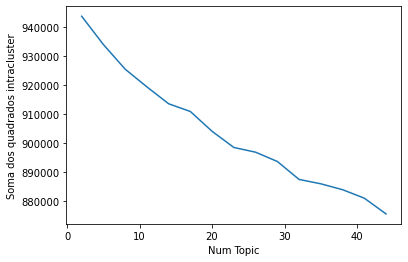

In [441]:
wcss = []
minimo=2
maximo=45
step=3

for n in tqdm(range(minimo, maximo, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(tfidf)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimo, maximo, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

O número ideal de clusters pode ser 14.

In [443]:
kmeans_model = KMeans(n_clusters=14, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)

X = kmeans_model.fit(tfidf)

labels=kmeans_model.labels_.tolist()

In [444]:
item_all_compras['topic'] = labels 

item_all_compras.to_csv('item_modeled_14_tfidf.csv')

In [474]:
item_all_compras[['DS_ITEM', 'topic']][item_all_compras['topic']==13].tail(100)

,DS_ITEM,topic
871907,SINAL. HORIZ. C/ TINTA BASE ACRILICA BRANCA DURAB. 24MESES (FAIXAS TRACEJADAS-EIXO-FAIXA CONTINUA ANTES DA FAIXA DE SEGURANÇA),13
872267,ÁCIDO VALPRÓICO 250mg (C1) - COTA DESTINADA A AMPLA,13
872268,ÁCIDO VALPRÓICO 500mg (C1) - COTA DESTINADA A AMPLA CONCORRE,13
872464,MANGUEIRA PARA EXTINTOR DE INCÊNDIO C0 ²,13
873112,BALÃO Nº 09 (PCT C/50 UN.) COR AMARELO,13
873113,BALÃO Nº 9 (PCT C/ 50 UND.) COR ROSA,13
873114,BALÃO Nº 09 (PCT C/50 UN.) COR AZUL,13
873184,"AÇO CA 50-8MM, BR C/ 12M",13
873185,AÇO CA 50-DIÂMETRO 10MM C/ 12M DE COMPRIMENTO,13
873186,AÇO CA 50- DIÂMETRO 12MM C/ 12 M DE COMPRIMENTO,13


In [477]:
remap_clusters = {0:'Móveis'
                    , 1:'Impressoras, toners e cartuchos'
                    , 2:'Materiais Hidráulicos, tubos e conexões'
                    , 3:'Materiais para reforma e construção'
                    , 4:'Outros'
                    , 5:'Outros'
                    , 6:'Pneus e serviços de recapagens'
                    , 7:'Insumos para construção civil'
                    , 8:'Materiais de instalação elétrica'
                    , 9:'Outros'
                    , 10:'Insumos para construção civil'
                    , 11:'Gêneros alimentícios'
                    , 12:'Fármacos'
                    , 13:'Outros'}

item_all_compras['Topicos'] = item_all_compras['topic'].map(remap_clusters)

In [480]:
item_all_compras.to_csv('item_modeled_final.csv')

# Análise dos dados
Após todo o processo de tratamento e clusterização, é possível fazer uma análise das licitações. Analisando as licitações, é possível observar:

In [5]:
licitacoes = pd.read_csv('licita_modeled_final.csv', index_col=0)
licitacoes.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_COMISSAO,ANO_COMISSAO,TP_COMISSAO,NR_PROCESSO,ANO_PROCESSO,TP_OBJETO,CD_TIPO_FASE_ATUAL,TP_LICITACAO,DS_OBJETO,VL_LICITACAO,VL_HOMOLOGADO,DS_OBJETO_TRATADO,topic,Topicos
0,84100,PM DE ESPERANÇA DO SUL,1.0,2016,CNV,12.0,2016.0,P,001,2016.0,OUS,ADH,MPR,Contratação de arbitragem dos jogos do 2º camp...,7000.0,6420.0,"['contratação', 'arbitragem', 'jogos', 'º', 'c...",15,Prestação de serviços
1,84100,PM DE ESPERANÇA DO SUL,4.0,2016,CNV,12.0,2016.0,P,003,2016.0,COM,ADH,MPR,Aquisição de merenda escolar,11216.5,NaN,"['aquisição', 'merenda', 'escolar']",11,Gêneros alimentícios
2,82701,CM DE XANGRI-LÁ,1.0,2016,PRP,12.0,2016.0,G,01,2016.0,COM,ADH,MPR,AQUISIÇÃO DE PROTOCOLADORA E FRAGMENTADORA DE ...,NaN,NaN,"['aquisição', 'protocoladora', 'fragmentadora'...",13,Outros
3,84100,PM DE ESPERANÇA DO SUL,6.0,2016,CNV,12.0,2016.0,P,005,2016.0,COM,ADH,MPR,Aquisição de materiais de limpeza para as dive...,59810.6,NaN,"['aquisição', 'materiais', 'limpeza', 'diversa...",8,Material de expediente/escritório
4,63900,PM DE COTIPORÃ,36.0,2016,PRD,NaN,NaN,NaN,344,2016.0,CSE,PUB,NSA,CONTRATAÇÃO DE EMPRESA PARA FORNECIMENTO E INS...,3835.0,NaN,"['contratação', 'empresa', 'fornecimento', 'in...",15,Prestação de serviços


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


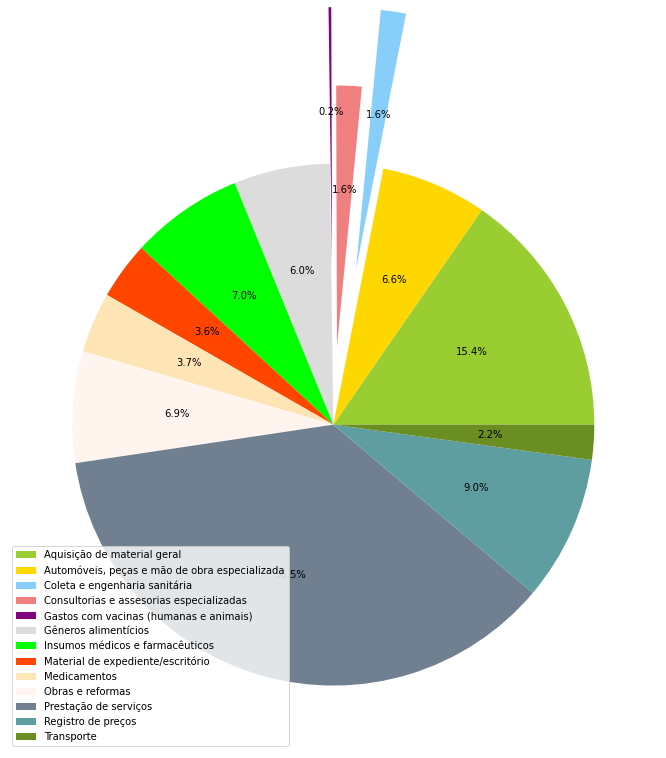

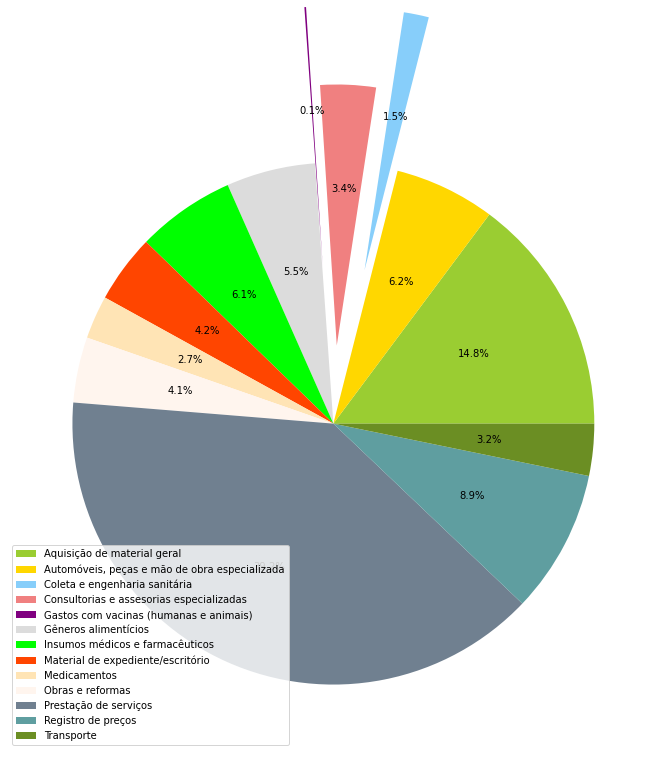

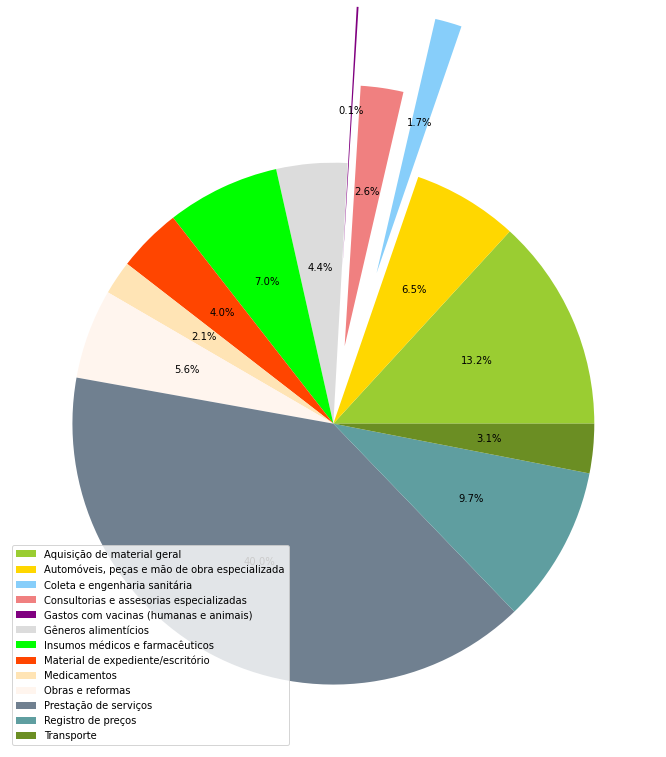

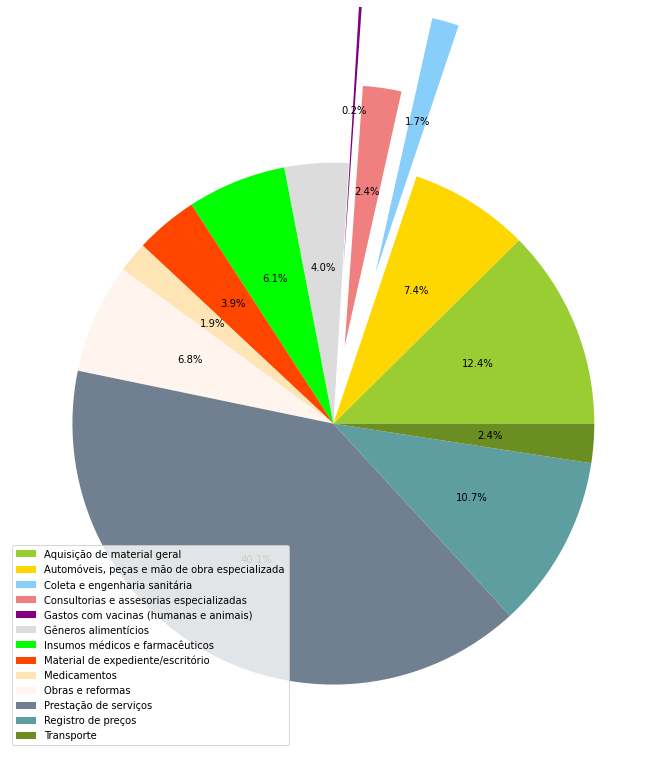

In [86]:
licitacoes_no_outros = licitacoes[licitacoes['Topicos']!='Outros']

for year in licitacoes_no_outros['ANO_LICITACAO'].unique():
    labels = [str(i)[8:-2] for i in list(licitacoes_no_outros[licitacoes_no_outros['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'Topicos']).size().index)]

    colors=['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple', 'gainsboro', 'lime', 'orangered', 'moccasin', 'seashell', 'slategrey', 'cadetblue', 'olivedrab']

    ax = licitacoes_no_outros[licitacoes_no_outros['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'Topicos']).size().plot(kind='pie', figsize=[23,12], colors=colors, autopct='%1.1f%%', labels=None, explode=(0, 0, 0.6, 0.3, 0.6, 0, 0, 0, 0, 0, 0, 0, 0))

    ax.get_yaxis().set_visible(False)

    plt.legend(loc="best", labels=labels)
    plt.show()

Conforme visto, a distribuição média das licitações não teve muitas mudanças ao longo dos anos, enquanto ainda há uma grande concentração de registros não categorizados (Outros).

Agora, avaliando a variação percentual das licitações ao longo dos anos:

In [7]:
df = licitacoes.groupby(['ANO_LICITACAO', 'Topicos']).size()

licitacoes_por_ano = df.reset_index().pivot(index='ANO_LICITACAO', columns=['Topicos'])

licitacoes_por_ano = licitacoes_por_ano.droplevel(0, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='Topicos', ylabel='ANO_LICITACAO'>

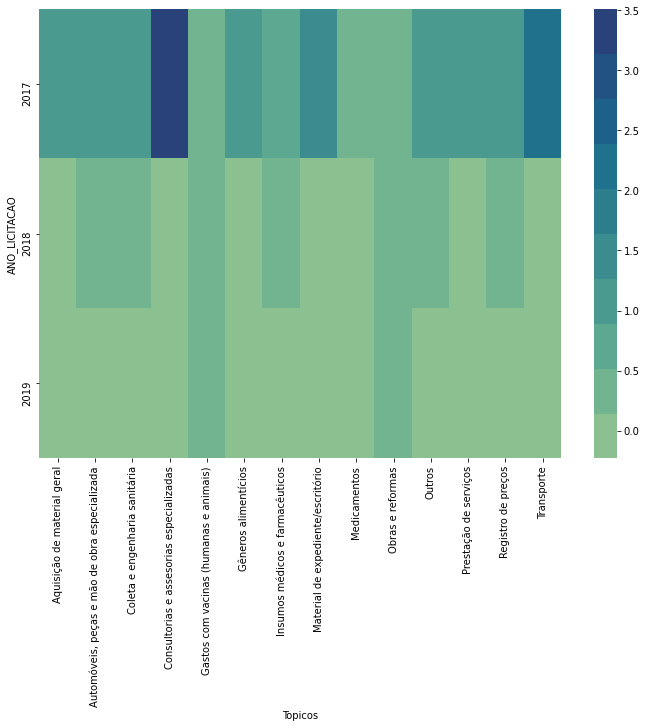

In [35]:
fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)
sns.heatmap(licitacoes_por_ano.pct_change().dropna(), cmap=sns.color_palette('crest', 10))

Conforme visto, 2019 foi um ano em que os contratos pouco variaram, chegando inclusive a haver variações negativas.

Por fim, avaliando o ticket médio das licitações:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


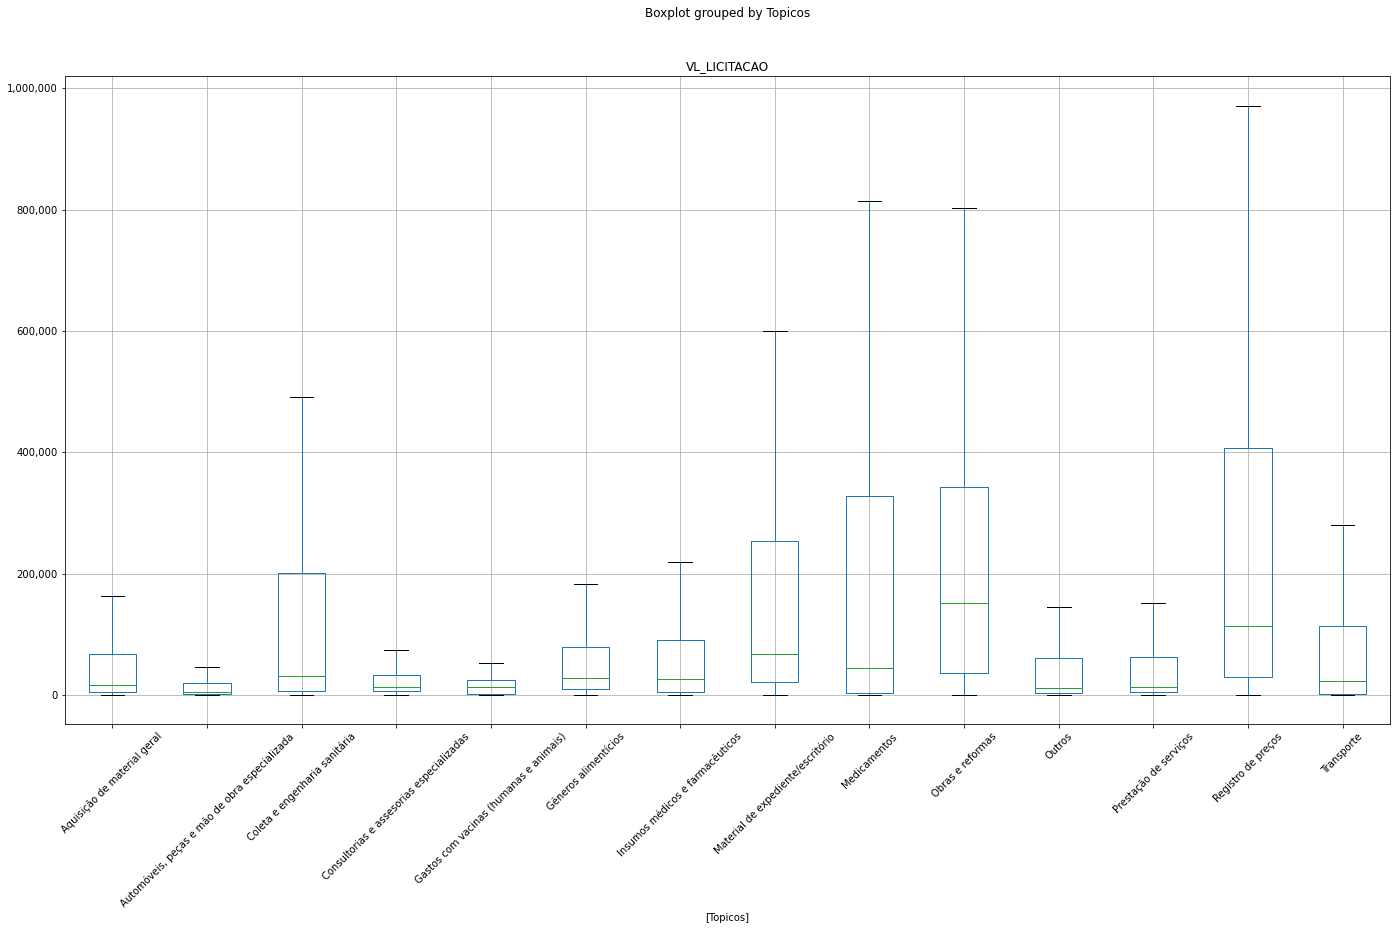

In [66]:
def scientific(x, pos):
    # x:  tick value - ie. what you currently see in yticks
    # pos: a position - ie. the index of the tick (from 0 to 9 in this example)~
    x = int(x)
    return "{:,}".format(x)

ax = licitacoes[['VL_LICITACAO', 'Topicos']].boxplot(by='Topicos', showfliers=False, figsize=[23,12])

scientific_formatter = FuncFormatter(scientific)
ax.yaxis.set_major_formatter(scientific_formatter)

plt.xticks(rotation=45)

plt.show()

Conforme visto, o gasto com obras e medicamentos representam os maiores tickets médios nas licitações. O Registro de preços, apesar de apresentar um ticket médio elevado, não representa compras necessariamente feitas, mas somente orçamentos feitos pelas instituições.

Por fim, fazendo a mesma análise somente nas licitações de compra:

In [72]:
compras = pd.read_csv('item_modeled_final.csv', index_col=0)
compras.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,DT_REF_VALOR_ESTIMADO,DS_ITEM_TRATADO,topic,Topicos
6,77200,17.0,2016,CNV,1,49,49,Xinafoato de salmeterol 25mcg + propionato de ...,12.0,FR,75.053,900.64,2016-11-30,"['xinafoato', 'salmeterol', 'propionato', 'flu...",4,Outros
7,77200,17.0,2016,CNV,1,48,48,Rosuvastatina cálcica 10mg – caixa com 30 comp...,24.0,CX,20.218,485.23,2016-11-30,"['rosuvastatina', 'cálcica', 'caixa', 'comprim...",4,Outros
8,77200,17.0,2016,CNV,1,47,47,Policresuleno 50mg/g; cloridrato de cinchocaín...,6.0,TB,11.264,67.58,2016-11-30,"['policresuleno', 'mgg', 'cloridrato', 'cincho...",4,Outros
9,77200,17.0,2016,CNV,1,46,46,Policarbofila cálcica 500mg – caixa com 30 com...,6.0,CX,25.795,154.77,2016-11-30,"['policarbofila', 'cálcica', 'caixa', 'comprim...",4,Outros
10,77200,17.0,2016,CNV,1,45,45,Oxcarbazepina 600mg – caixa com 30 comprimidos,12.0,CX,31.889,382.67,2016-11-30,"['oxcarbazepina', 'caixa', 'comprimidos']",4,Outros


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


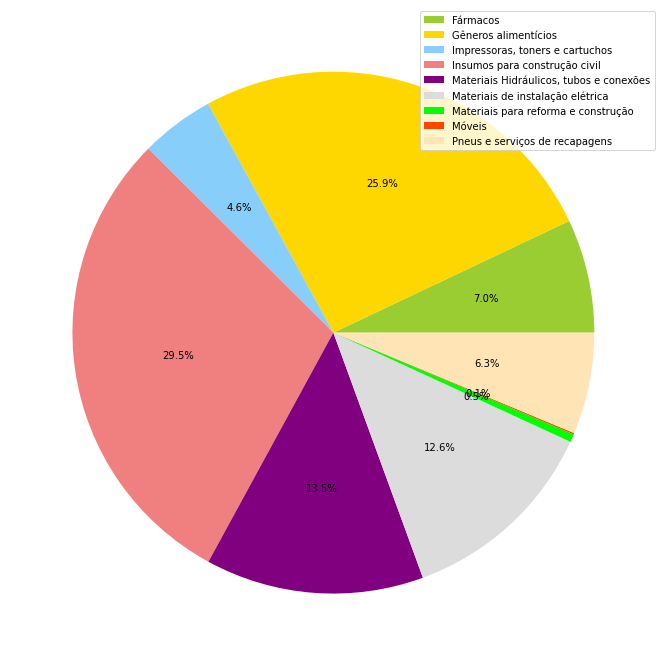

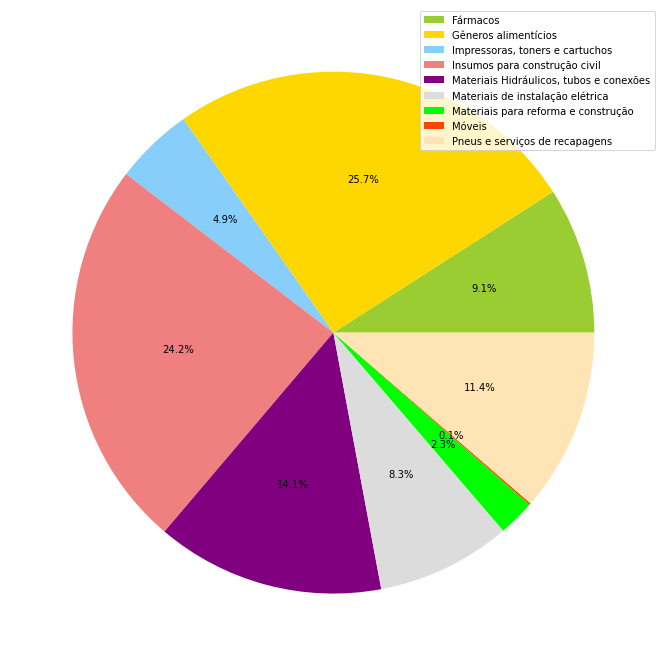

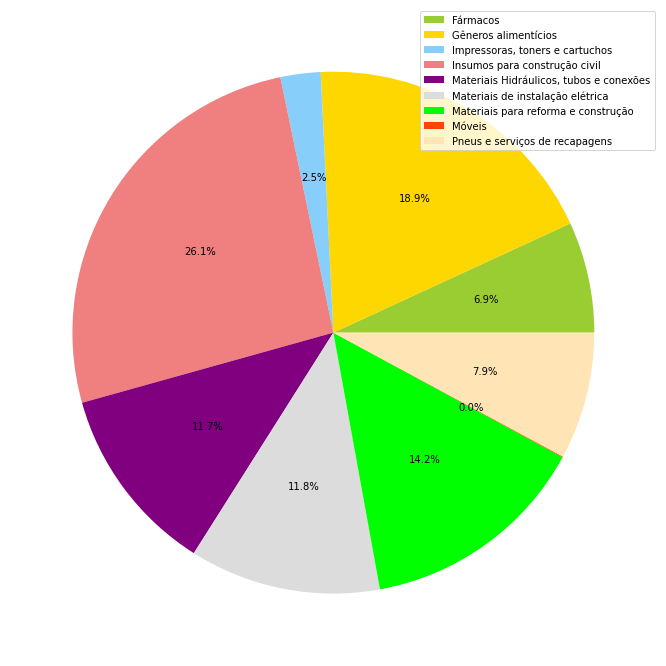

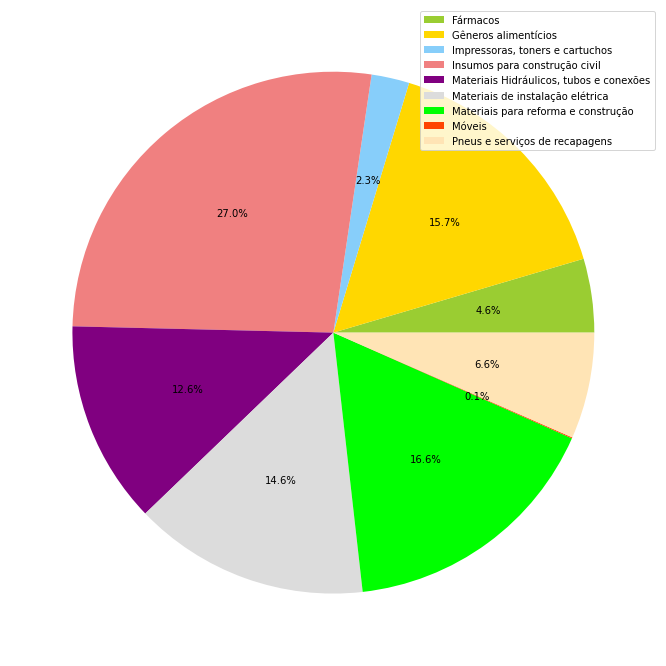

In [85]:
compras_no_outros = compras[compras['Topicos']!='Outros']

for year in compras_no_outros['ANO_LICITACAO'].unique():

    labels = [str(i)[8:-2] for i in list(compras_no_outros[compras_no_outros['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'Topicos']).size().index)]

    colors=['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple', 'gainsboro', 'lime', 'orangered', 'moccasin', 'seashell', 'slategrey', 'cadetblue', 'olivedrab']

    ax = compras_no_outros[compras_no_outros['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'Topicos']).size().plot(kind='pie', figsize=[23,12], colors=colors, autopct='%1.1f%%', labels=None)

    ax.get_yaxis().set_visible(False)

    plt.legend(loc="best", labels=labels)
    plt.show()

Conforme visto, as compras de insumos para a construção civil representam o maior montante das compras em quantidade. Analisando a variação percentual anual:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='Topicos', ylabel='ANO_LICITACAO'>

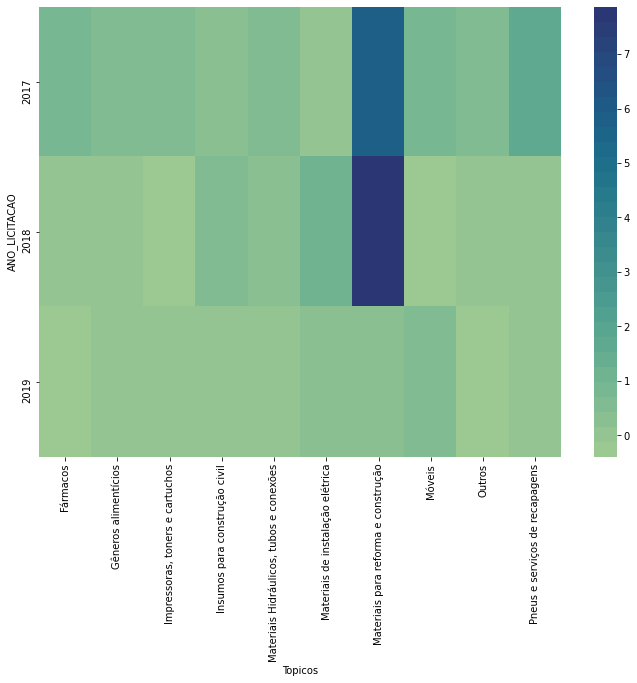

In [93]:
df = compras.groupby(['ANO_LICITACAO', 'Topicos']).size()

compras_por_ano = df.reset_index().pivot(index='ANO_LICITACAO', columns=['Topicos'])

compras_por_ano = compras_por_ano.droplevel(0, axis=1)


fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)
sns.heatmap(compras_por_ano.pct_change().dropna(), cmap=sns.color_palette('crest', 30))

In [92]:
compras_por_ano.pct_change()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topicos,Fármacos,Gêneros alimentícios,"Impressoras, toners e cartuchos",Insumos para construção civil,"Materiais Hidráulicos, tubos e conexões",Materiais de instalação elétrica,Materiais para reforma e construção,Móveis,Outros,Pneus e serviços de recapagens
ANO_LICITACAO,,,,,,,,,,
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,0.940476,0.490075,0.599476,0.234077,0.574675,0.000000,5.910569,0.863636,0.697918,1.718274
2018,0.064855,0.034593,-0.282051,0.514574,0.161575,0.993645,7.865882,-0.390244,0.112140,-0.024977
2019,-0.290261,-0.110590,0.008359,0.104037,0.148620,0.317660,0.244294,0.440000,-0.139222,-0.108690


Conforme visto, os gastos com materiais para construção tiveram um crescimento expressivo em 2018, assim como os demais materiais para reforma em construção. Os gastos com móveis também apresentaram um aumento expressivo em 2019.

Por fim, a análise do ticket médio:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


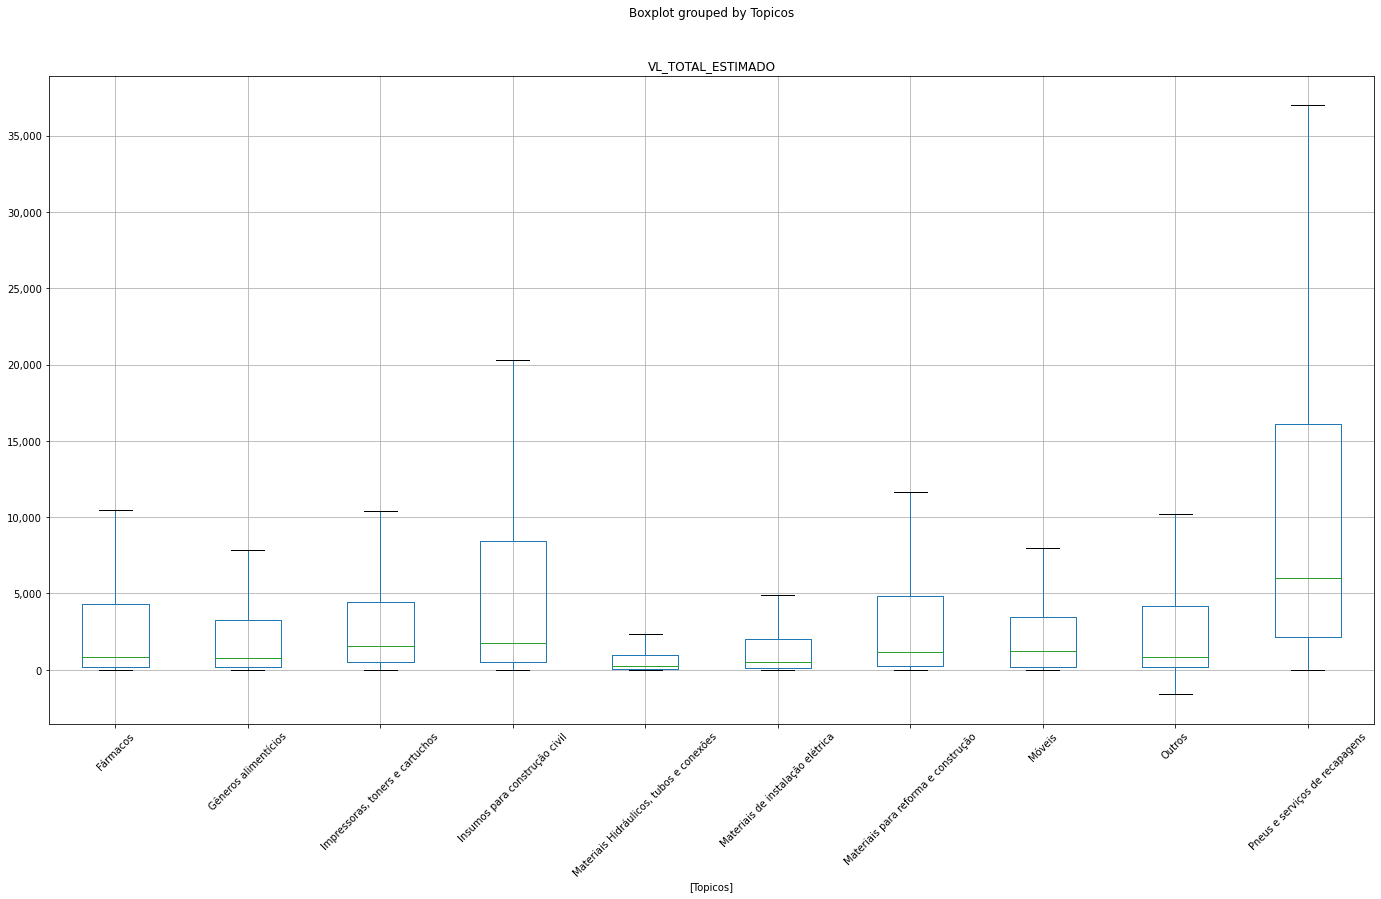

In [95]:
ax = compras[['VL_TOTAL_ESTIMADO', 'Topicos']].boxplot(by='Topicos', showfliers=False, figsize=[23,12])

scientific_formatter = FuncFormatter(scientific)
ax.yaxis.set_major_formatter(scientific_formatter)

plt.xticks(rotation=45)

plt.show()

Como visto, o ticket médio de gastos com Insumos para a construção civil e Pneus e serviços de recapagens apresentam o maior ticket médio.

# Conclusão
O trabalho desenvolvido apresentou bons resultados e conseguiu classificar bem as licitações e os objetos adquiridos em cada uma. Conforme visto, há uma clara predominância dos gastos com serviços e compras nas licitações. Ao se analisar o ticket médio, os gastos com insumos para a construção civil e Pneus e serviços relacionados apresentam um claro destaque em relação aos demais segmentos, enquanto os insumos para a construção e gastos com alimentação representam grande parte das licitações de compra.

As classificações feitas usadas também para detectar licitações com valores fora do padrão, assim como um refinamento das análises poderia ser feita para realizar as avaliações por região do Estado ou até cidade, podendo ser uma informação importante para entender quais regiões do estado apresentam maior potencial para os players do mercado.

Nos algoritmos construídos, nota-se que alguns registros não conseguiram ser clusterizados, sendo classificado como "Outros". Este fato impacta na qualidade das análises e, para resolver este problema, os algoritmos de classificação precisariam ser refinados.